# **Setup**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset from Google Colab directory
df = pd.read_csv("/content/Folds5x2_pp.csv")

# Display first 5 rows
df.head()



,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.4,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.5,1009.23,96.62,473.9


# **Understand the Dataset**


In [ ]:
# Check number of rows and columns
print("Dataset shape:", df.shape)

# Display column names
print("Column names:", df.columns)

# Check data types
df.dtypes

# Statistical summary of the dataset
df.describe()


Dataset shape: (47844, 5)
Column names: Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')


,AT,V,AP,RH,PE
count,47844,47844,47844,47844,47844
unique,2774,635,2518,4547,4837
top,25.21,70.32,1013.88,100.09,468.8
freq,70,305,80,130,45


# **Feature Selection & Train–Test Split**

In [ ]:
# Select input features (independent variables)
X = df[["AT", "V", "AP", "RH"]]

# Select target variable (dependent variable)
y = df["PE"]

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# Check shapes after split
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (38275, 4)
Testing set shape: (9569, 4)


# **Train Linear Regression**

In [ ]:
df.head(10)
df.dtypes
# Convert all columns to numeric (force errors to NaN)
df = df.apply(pd.to_numeric, errors="coerce")

# Drop rows with NaN (if any)
df = df.dropna()

# Recheck types
df.dtypes

X = df[["AT", "V", "AP", "RH"]]
y = df["PE"]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred_lin = lin_model.predict(X_test)


# **Evaluate Linear Regression Performance**

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Mean Squared Error
mse_lin = mean_squared_error(y_test, y_pred_lin)

# R-squared score
r2_lin = r2_score(y_test, y_pred_lin)

print("Linear Regression Performance")
print("MSE:", mse_lin)
print("R² Score:", r2_lin)


Linear Regression Performance
MSE: 20.21612606628018
R² Score: 0.9304754216296223


# **Train Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Performance")
print("MSE:", mse_rf)
print("R² Score:", r2_rf)



Random Forest Performance
MSE: 0.07559682781406933
R² Score: 0.9997400175699993


# **Hyperparameter Tuning**



In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5]
}

# Initialize base model
rf_base = RandomForestRegressor(random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1
)

# Train grid search
grid_search.fit(X_train, y_train)

# Best tuned model
best_rf = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)


Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


# **Feature Importance**

In [ ]:
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importance


,Feature,Importance
0,AT,0.904218
1,V,0.058168
2,AP,0.020501
3,RH,0.017113


# **Final Evaluation + Visualization**

Tuned Random Forest Performance
MSE: 0.07559682781406933
R² Score: 0.9997400175699993


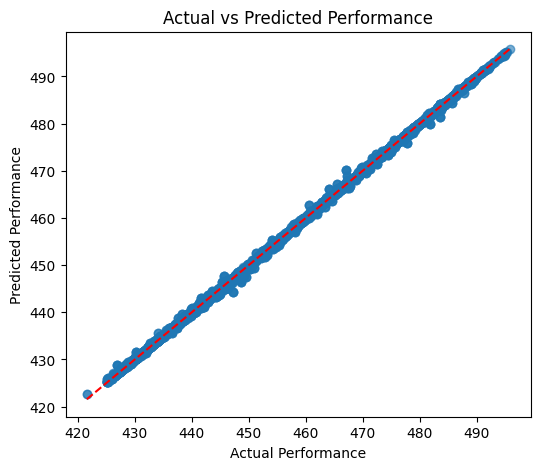

In [ ]:
# Predictions using tuned model
y_pred_best = best_rf.predict(X_test)

# Metrics
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("Tuned Random Forest Performance")
print("MSE:", mse_best)
print("R² Score:", r2_best)

# Actual vs Predicted plot
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Performance")
plt.ylabel("Predicted Performance")
plt.title("Actual vs Predicted Performance")
plt.show()


# **Create Efficiency as Second Target**

In [ ]:
# Normalize PE to represent efficiency (0 to 1 scale)
df["Efficiency"] = df["PE"] / df["PE"].max()

# Clip to avoid numerical edge issues
df["Efficiency"] = df["Efficiency"].clip(0.6, 1.0)

df[["PE", "Efficiency"]].head()


,PE,Efficiency
0,463.26,0.934444
1,444.37,0.896341
2,488.56,0.985477
3,446.48,0.900597
4,473.90,0.955906


# **Multi-Target Split**

In [ ]:
X = df[["AT", "V", "AP", "RH"]]

y_power = df["PE"]
y_efficiency = df["Efficiency"]

X_train, X_test, yP_train, yP_test, yE_train, yE_test = train_test_split(
    X,
    y_power,
    y_efficiency,
    test_size=0.2,
    random_state=42
)


# **Train Models for BOTH Targets**

In [ ]:
# Linear model for Power
lin_power = LinearRegression()
lin_power.fit(X_train, yP_train)

# Linear model for Efficiency
lin_eff = LinearRegression()
lin_eff.fit(X_train, yE_train)


# Random Forest for Power
rf_power = best_rf
rf_power.fit(X_train, yP_train)

# Random Forest for Efficiency
rf_eff = RandomForestRegressor(
    n_estimators=best_rf.n_estimators,
    max_depth=best_rf.max_depth,
    min_samples_split=best_rf.min_samples_split,
    random_state=42
)

rf_eff.fit(X_train, yE_train)



RandomForestRegressor(n_estimators=200, random_state=42)

# **Evaluate Both Targets**

In [ ]:
# Predictions
yP_pred = rf_power.predict(X_test)
yE_pred = rf_eff.predict(X_test)

# Power metrics
print("Power Prediction")
print("MSE:", mean_squared_error(yP_test, yP_pred))
print("R² :", r2_score(yP_test, yP_pred))

# Efficiency metrics
print("\nEfficiency Prediction")
print("MSE:", mean_squared_error(yE_test, yE_pred))
print("R² :", r2_score(yE_test, yE_pred))


Power Prediction
MSE: 0.07559682781406933
R² : 0.9997400175699993

Efficiency Prediction
MSE: 3.109035812972675e-07
R² : 0.9997372098289309


# **Efficiency Visualization**

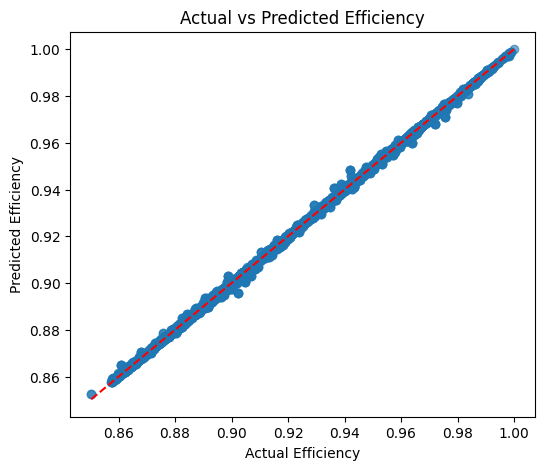

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(yE_test, yE_pred, alpha=0.6)
plt.plot([yE_test.min(), yE_test.max()],
         [yE_test.min(), yE_test.max()], "r--")
plt.xlabel("Actual Efficiency")
plt.ylabel("Predicted Efficiency")
plt.title("Actual vs Predicted Efficiency")
plt.show()
